In [ ]:
import pyspark
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('nyc_taxi_notebook_2') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 11:12:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df_yellow = spark.read\
    .parquet(f'tmp-data/pq/yellow/*/*')

## 🔝
Job has a single stage 
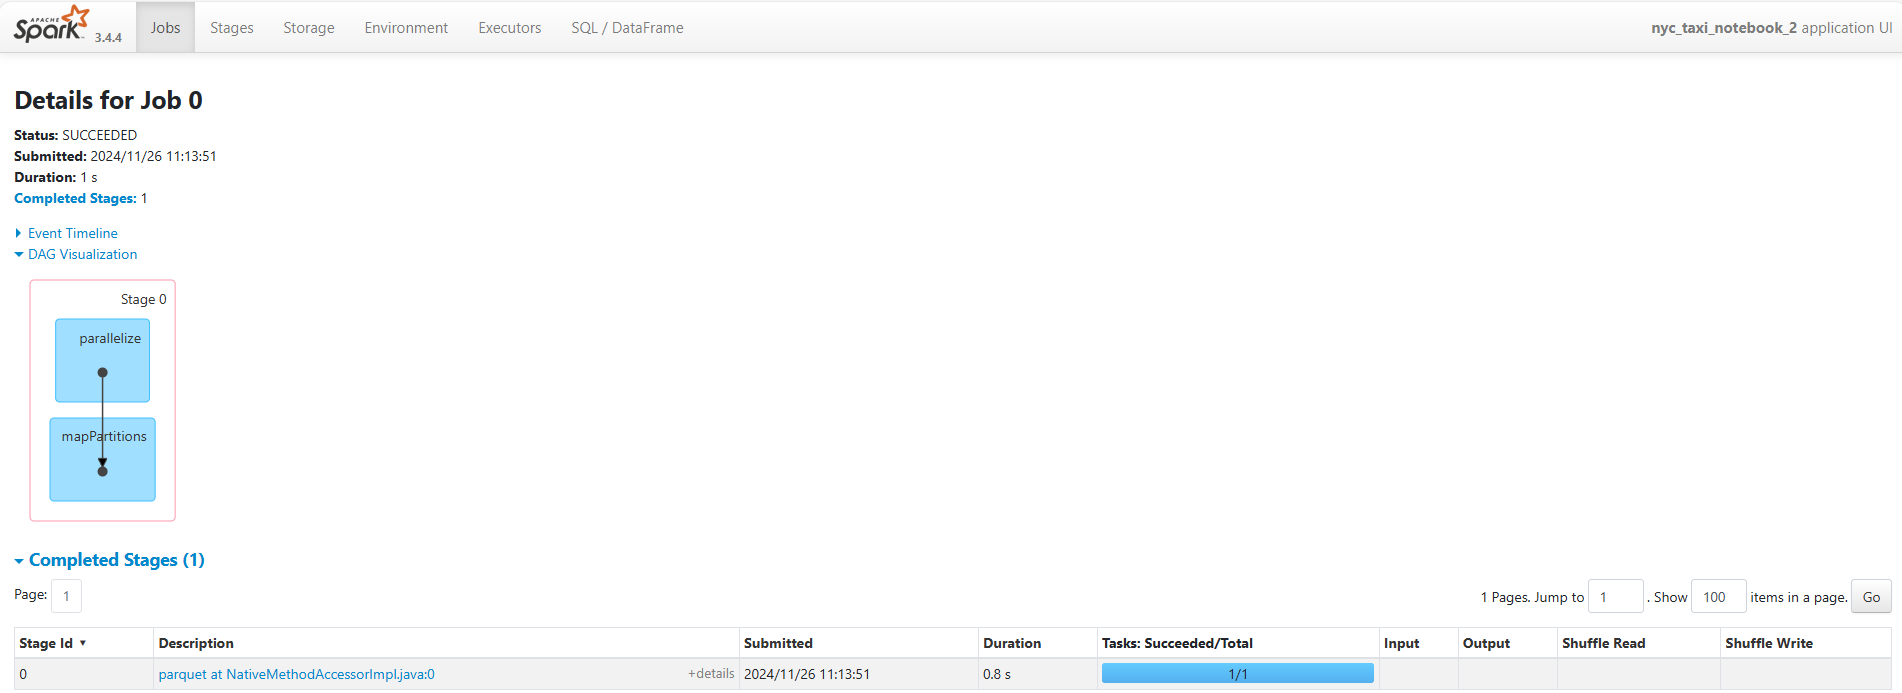

Stage contains 2 tasks? 
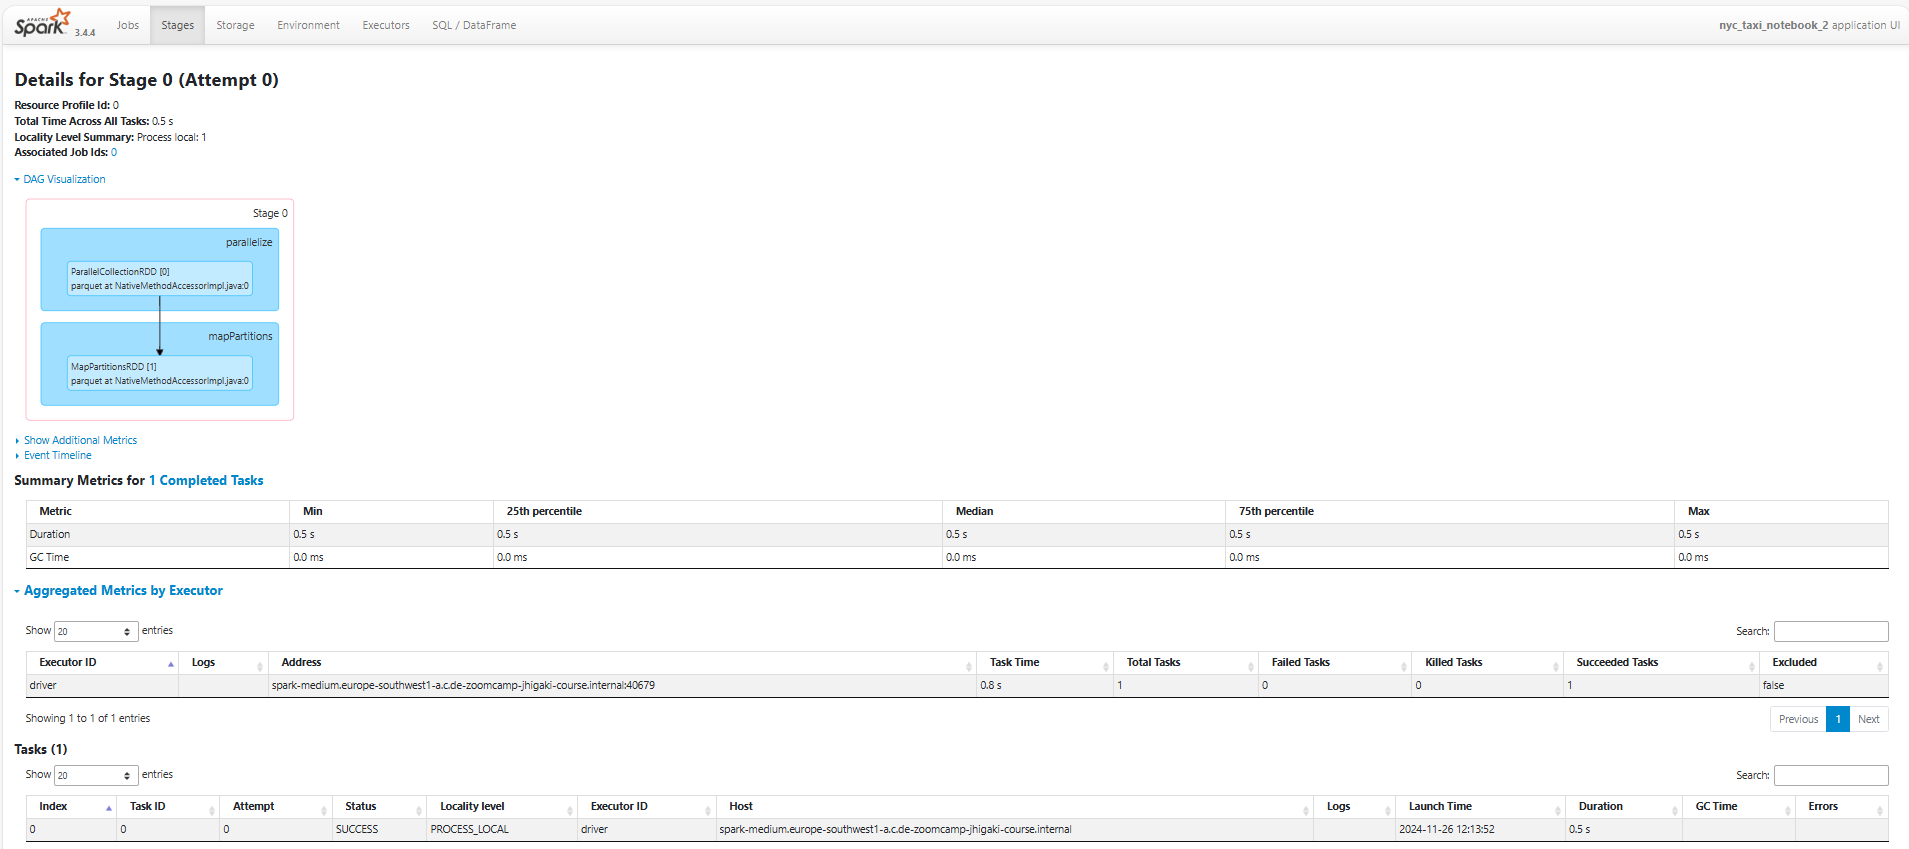


In [4]:
df_green = spark.read\
    .parquet(f'tmp-data/pq/green/*/*')

## 🔝
1 job, single stage
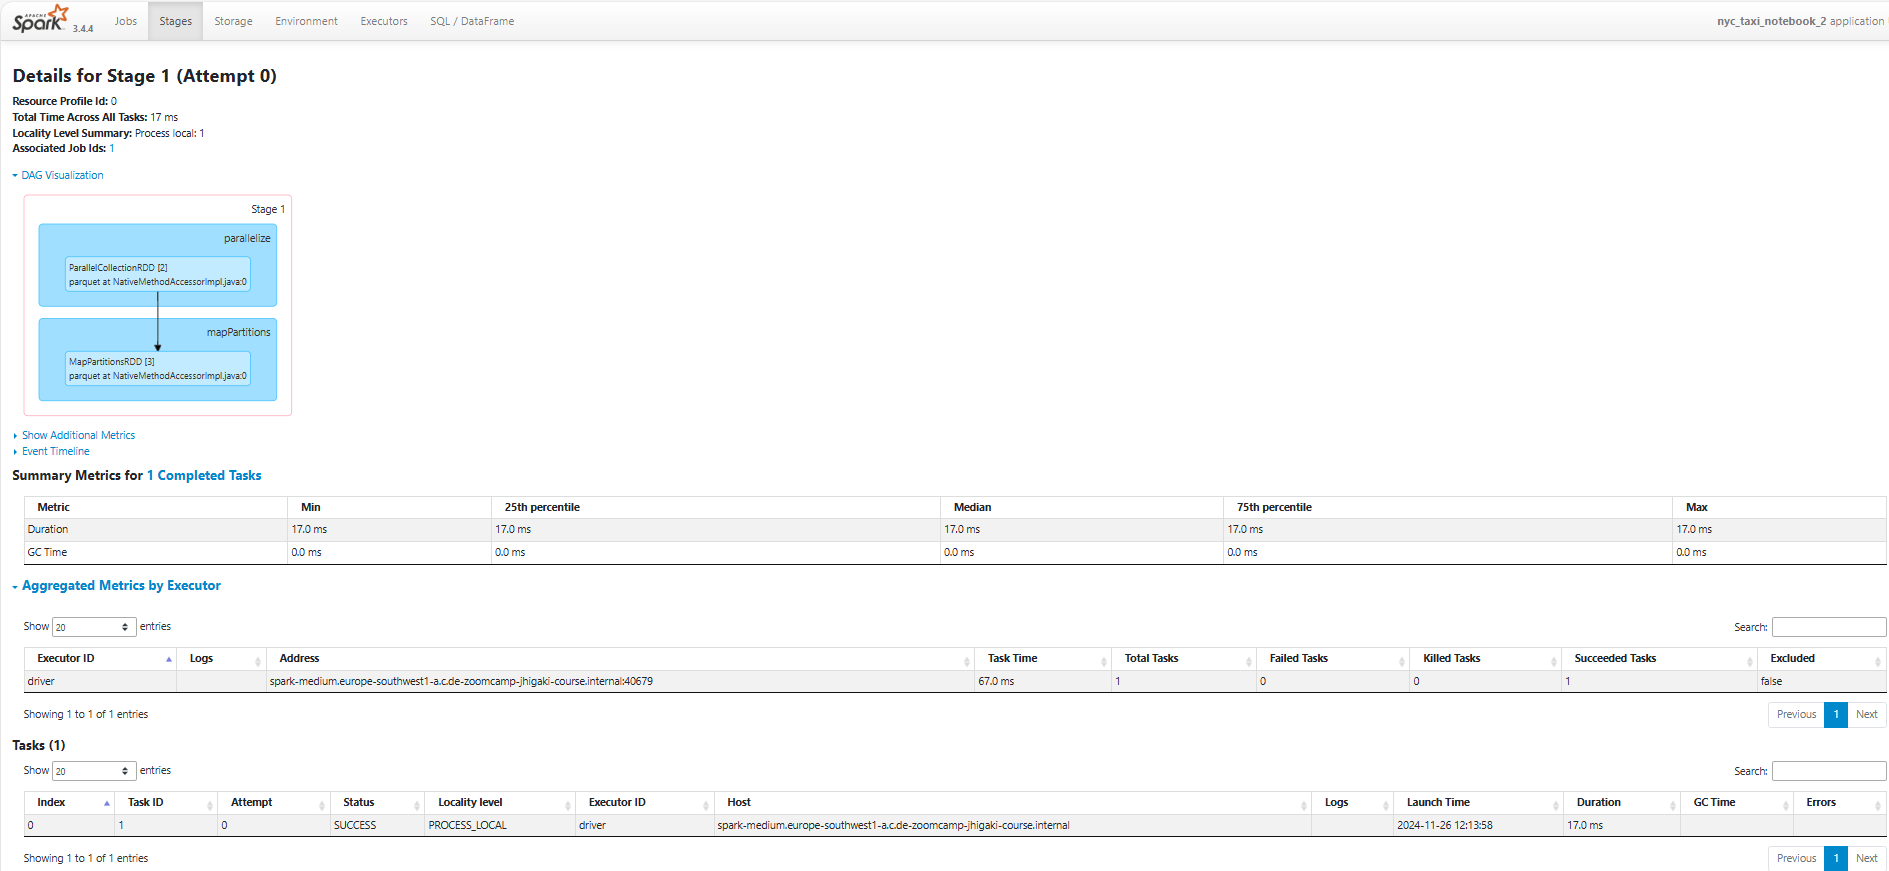

In [5]:
df_yellow.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2019-01-15 07:18:13|  2019-01-15 07:27:56|            1.0|         1.16|       1.0|                 N|          48|         161|           1|        8.0|  0.0|    0.5|       1.

## 🔝

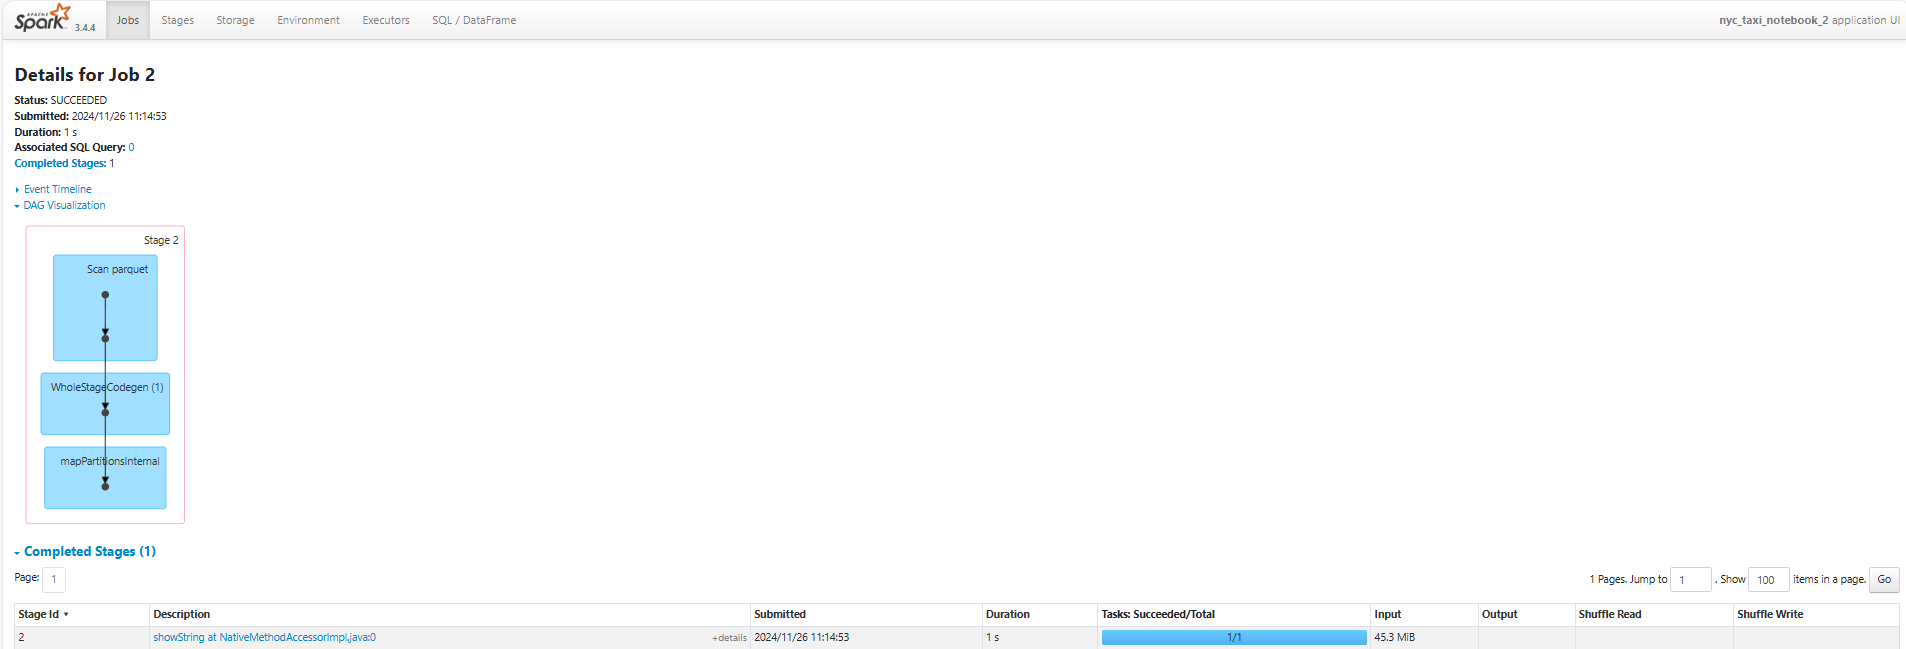

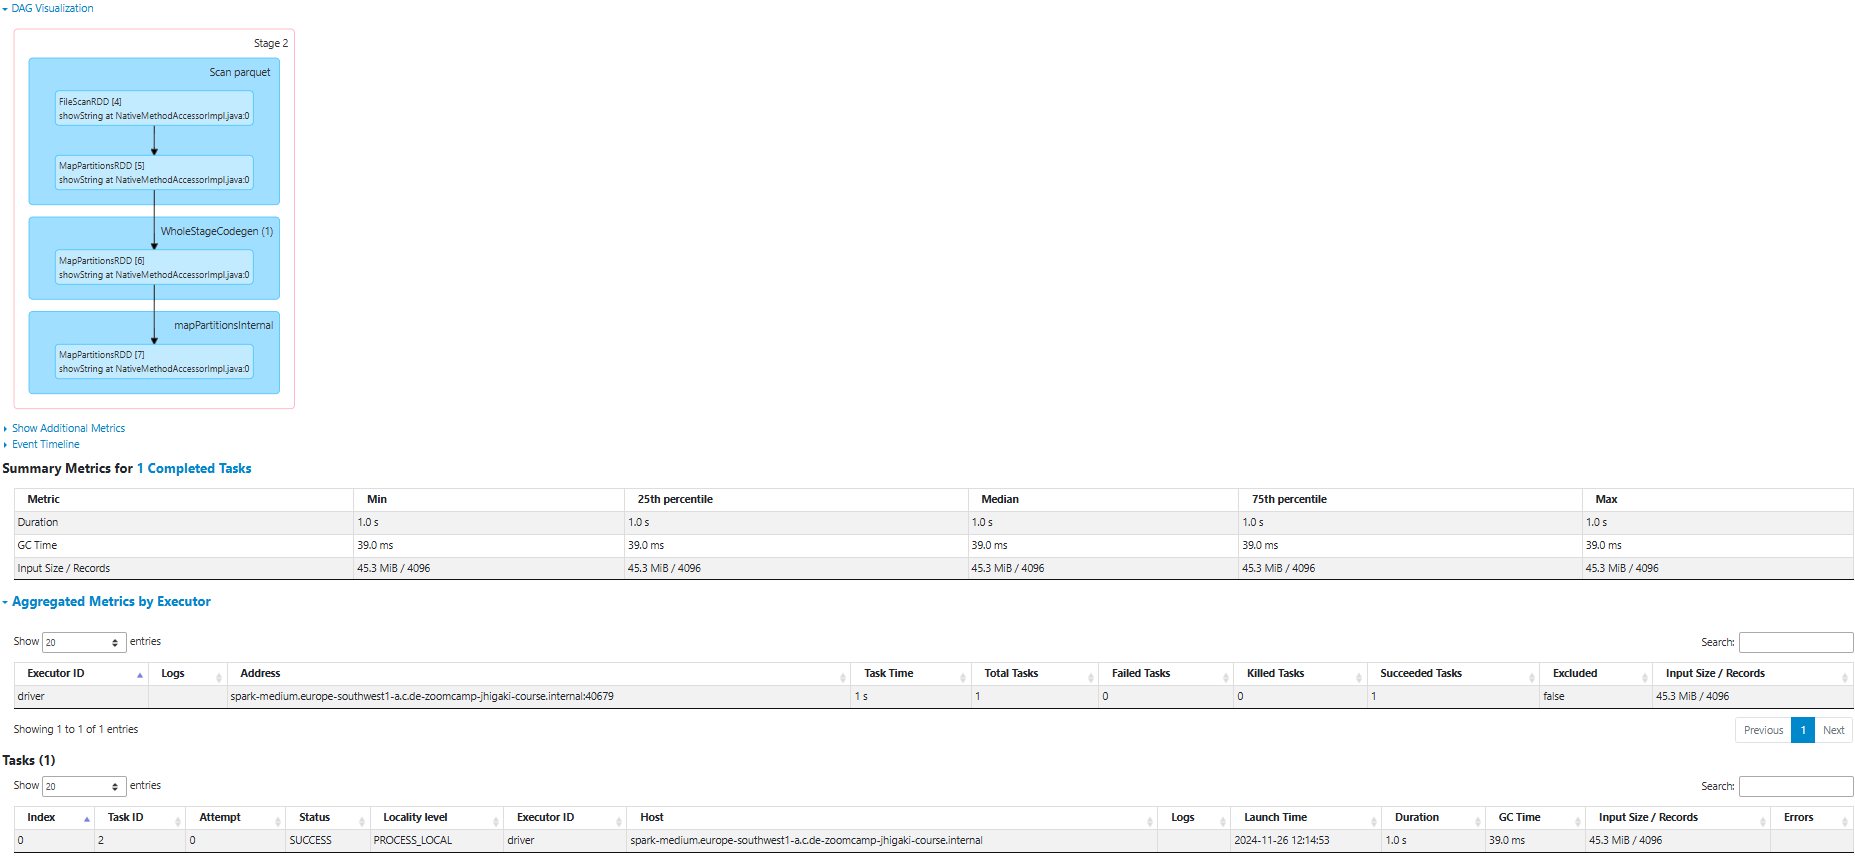

In [6]:
y_g_columns = ['VendorID',\
                'pickup_datetime',\
                'dropoff_datetime',\
                'passenger_count',\
                'PULocationID',\
                'DOLocationID',\
                'total_amount']

## Transformation 
1. Union yellow and green. 

In [7]:
df_yellow_transformed = df_yellow\
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')\
    .withColumnRenamed('tpep_dropoff_datetime', 'dropoff_datetime')\
    .select(y_g_columns)

df_green_transformed = df_green\
    .withColumnRenamed('lpep_pickup_datetime', 'pickup_datetime')\
    .withColumnRenamed('lpep_dropoff_datetime', 'dropoff_datetime')\
    .select(y_g_columns)


In [8]:
from pyspark.sql import functions as F

In [9]:
df_yg = df_yellow_transformed\
        .withColumn('service_type',F.lit('yellow') )\
        .unionAll(\
                df_green_transformed \
                    .withColumn('service_type', F.lit('green'))
        )

## Transformation 
1. create date fields
1. set weird date comment 

In [10]:
from  datetime import date

In [11]:
def date_comment(reference_date: date) -> str:
    isoc = reference_date.isocalendar()
    result = ""
    if isoc.week == 1: 
        result += f"First week of {isoc.year} "
    else:
        result += f" Year: {isoc.year} Week: {isoc.week}"
    if isoc.weekday == 5:
        result +=  f" It's Fridaaaay"
    else:
        result += f" Weekday: {isoc.weekday}"
    return result

## testing the function
(thank you ms Copilot 🤖 )

In [12]:

# Test cases
print("Running manual tests...")

assert date_comment(date(2022, 1, 3)) == "First week of 2022  Weekday: 1", "Test case 1 failed"
assert date_comment(date(2022, 5, 10)) == " Year: 2022 Week: 19 Weekday: 2", "Test case 2 failed"
assert date_comment(date(2023, 1, 6)) == "First week of 2023  It's Fridaaaay", "Test case 3 failed"
assert date_comment(date(2022, 12, 30)) == " Year: 2022 Week: 52 It's Fridaaaay", "Test case 4 failed"
assert date_comment(date(2022, 8, 10)) == " Year: 2022 Week: 32 Weekday: 3", "Test case 5 failed"

print("All tests passed!")


Running manual tests...
All tests passed!


In [13]:
from pyspark.sql import types
  
date_comment_udf = F.udf(date_comment, returnType=types.StringType())

In [14]:
df_yg_transformed = df_yg \
    .withColumn('pickup_date', F.to_date('pickup_datetime'))\
    .withColumn('pickup_date', F.to_date('pickup_datetime'))\
    .withColumn('pickup_date_comment', date_comment_udf('pickup_datetime'))

🔝

So far No spark job, as these are just transformations, not actions.

In [15]:
df_yg_transformed.show(10)

+--------+-------------------+-------------------+---------------+------------+------------+------------+------------+-----------+--------------------+
|VendorID|    pickup_datetime|   dropoff_datetime|passenger_count|PULocationID|DOLocationID|total_amount|service_type|pickup_date| pickup_date_comment|
+--------+-------------------+-------------------+---------------+------------+------------+------------+------------+-----------+--------------------+
|       2|2019-01-15 07:18:13|2019-01-15 07:27:56|            1.0|          48|         161|         9.8|      yellow| 2019-01-15| Year: 2019 Week:...|
|       1|2019-01-10 16:07:59|2019-01-10 16:17:15|            1.0|         264|         237|         9.3|      yellow| 2019-01-10| Year: 2019 Week:...|
|       2|2019-01-15 14:09:45|2019-01-15 14:24:41|            5.0|         237|         170|       14.16|      yellow| 2019-01-15| Year: 2019 Week:...|
|       2|2019-01-24 11:56:55|2019-01-24 12:02:19|            1.0|         170|         

🔝 Execution generated 

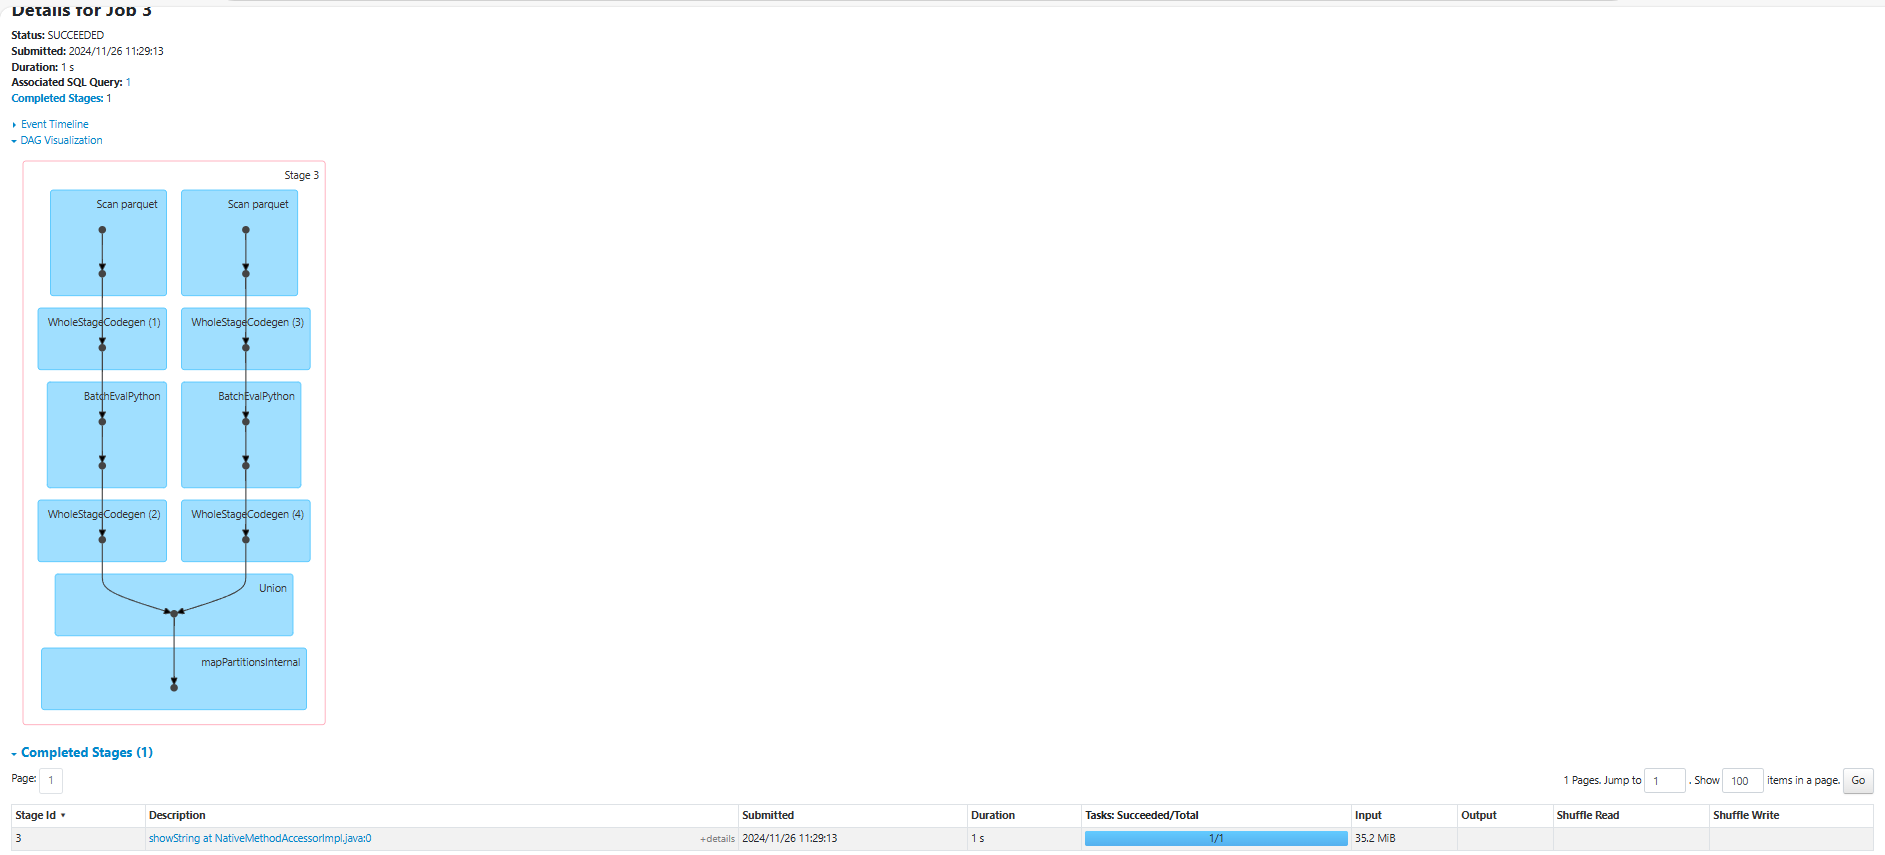

| Stage's DAG | Stage's Metrics / Tasks  |
| --- | --- |
| 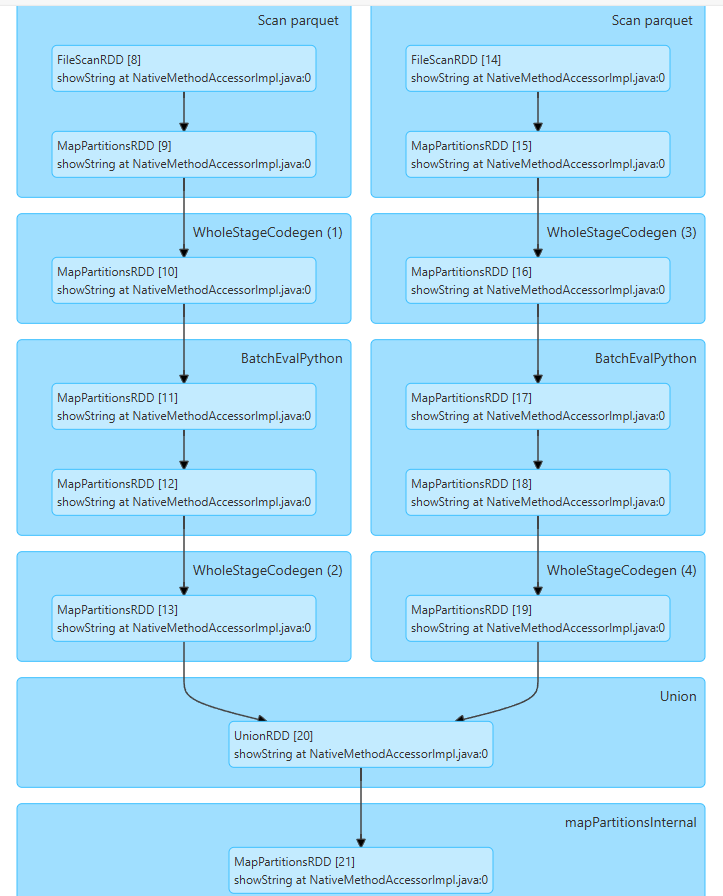 | 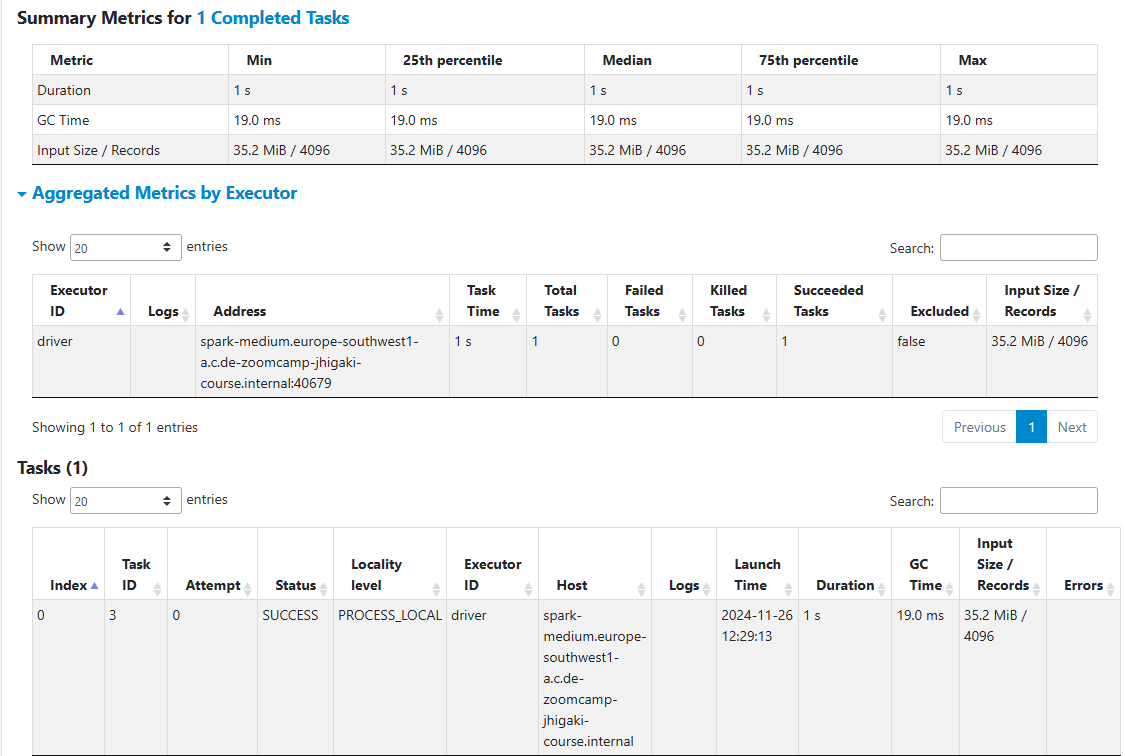 |

It processed 4096 records WHY

**I think it generated only 1 task because I'm doing a show 10**

In [19]:
!tree tmp-data/pq/*/2019/01

tmp-data/pq/fhv/2019/01
├── _SUCCESS
├── part-00000-280eb4fc-a1b5-42ba-9e6c-d01869f9d57b-c000.snappy.parquet
├── part-00001-280eb4fc-a1b5-42ba-9e6c-d01869f9d57b-c000.snappy.parquet
├── part-00002-280eb4fc-a1b5-42ba-9e6c-d01869f9d57b-c000.snappy.parquet
└── part-00003-280eb4fc-a1b5-42ba-9e6c-d01869f9d57b-c000.snappy.parquet
tmp-data/pq/green/2019/01
├── _SUCCESS
├── part-00000-aa48fd5f-bf05-4667-90df-233dcfbc7e9e-c000.snappy.parquet
├── part-00001-aa48fd5f-bf05-4667-90df-233dcfbc7e9e-c000.snappy.parquet
├── part-00002-aa48fd5f-bf05-4667-90df-233dcfbc7e9e-c000.snappy.parquet
└── part-00003-aa48fd5f-bf05-4667-90df-233dcfbc7e9e-c000.snappy.parquet
tmp-data/pq/yellow/2019/01
├── _SUCCESS
├── part-00000-8aff6ca3-bf91-4ee4-9cde-9ead8cac9ef4-c000.snappy.parquet
├── part-00001-8aff6ca3-bf91-4ee4-9cde-9ead8cac9ef4-c000.snappy.parquet
├── part-00002-8aff6ca3-bf91-4ee4-9cde-9ead8cac9ef4-c000.snappy.parquet
└── part-00003-8aff6ca3-bf91-4ee4-9cde-9ead8cac9ef4-c000.snappy.parquet

3 directories, 15 f

In [21]:
print(f"yellow entire folder 2019-01 count--: {spark.read.parquet(f'tmp-data/pq/yellow/2019/01').count()}")
print(f"yellow first file 2019-01 count--: {spark.read.parquet(f'tmp-data/pq/yellow/2019/01/part-00000-8aff6ca3-bf91-4ee4-9cde-9ead8cac9ef4-c000.snappy.parquet').count()}")
print(f"green entire folder 2019-01 count--: {spark.read.parquet(f'tmp-data/pq/green/2019/01').count()}")
print(f"green first file 2019-01 count--: {spark.read.parquet(f'tmp-data/pq/green/2019/01/part-00000-aa48fd5f-bf05-4667-90df-233dcfbc7e9e-c000.snappy.parquet').count()}")

yellow entire folder 2019-01 count--: 7696617
yellow first file 2019-01 count--: 1924154
green entire folder 2019-01 count--: 672105
green first file 2019-01 count--: 168026


🔝 
I don't know why it only  processed 4096 records when doing show(10)

Make the dataframe available for SQL


In [16]:
# df_yg_transformed.registerTempTable('y_g_tripdata') spark < 3.0
df_yg_transformed.createOrReplaceTempView('y_g_tripdata') # spark >= 3.0


In [17]:
spark.sql("""
    SELECT
        service_type,
        count(1)
    FROM
        y_g_tripdata
    GROUP BY 
        service_type
    """).show()

+------------+--------+
|service_type|count(1)|
+------------+--------+
|      yellow|14745987|
|       green| 1287699|
+------------+--------+



🔝 Execution generated 2 Jobs (total count: 16 033 686)
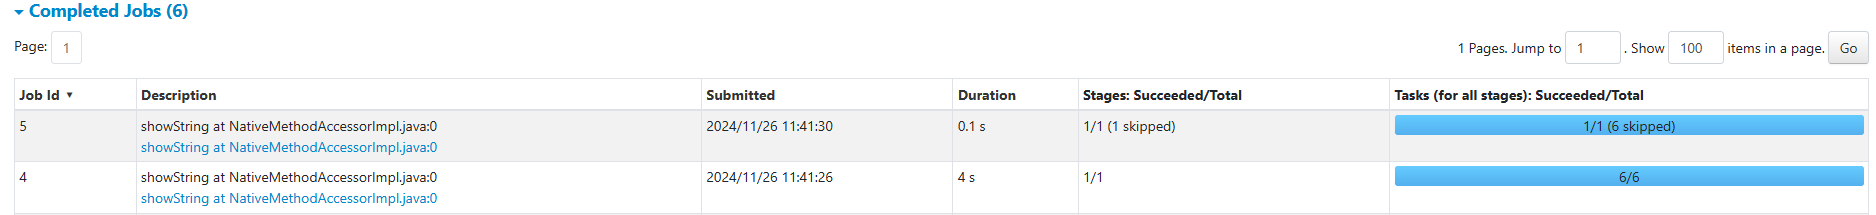

## Job 1 with 1 stage
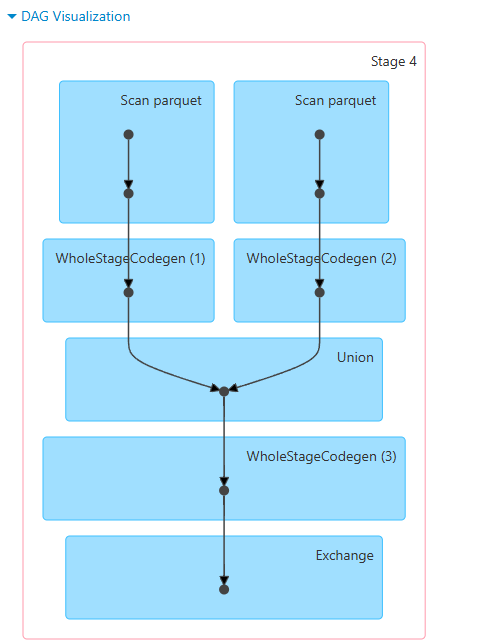


| Stage's DAG | Stage's Metrics / Tasks  |
| --- | --- |
| 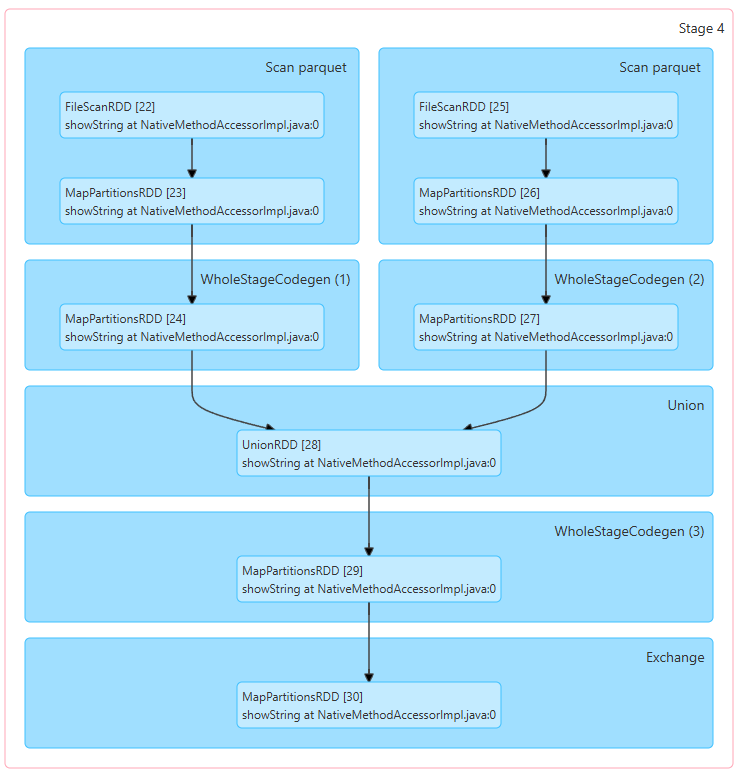 | 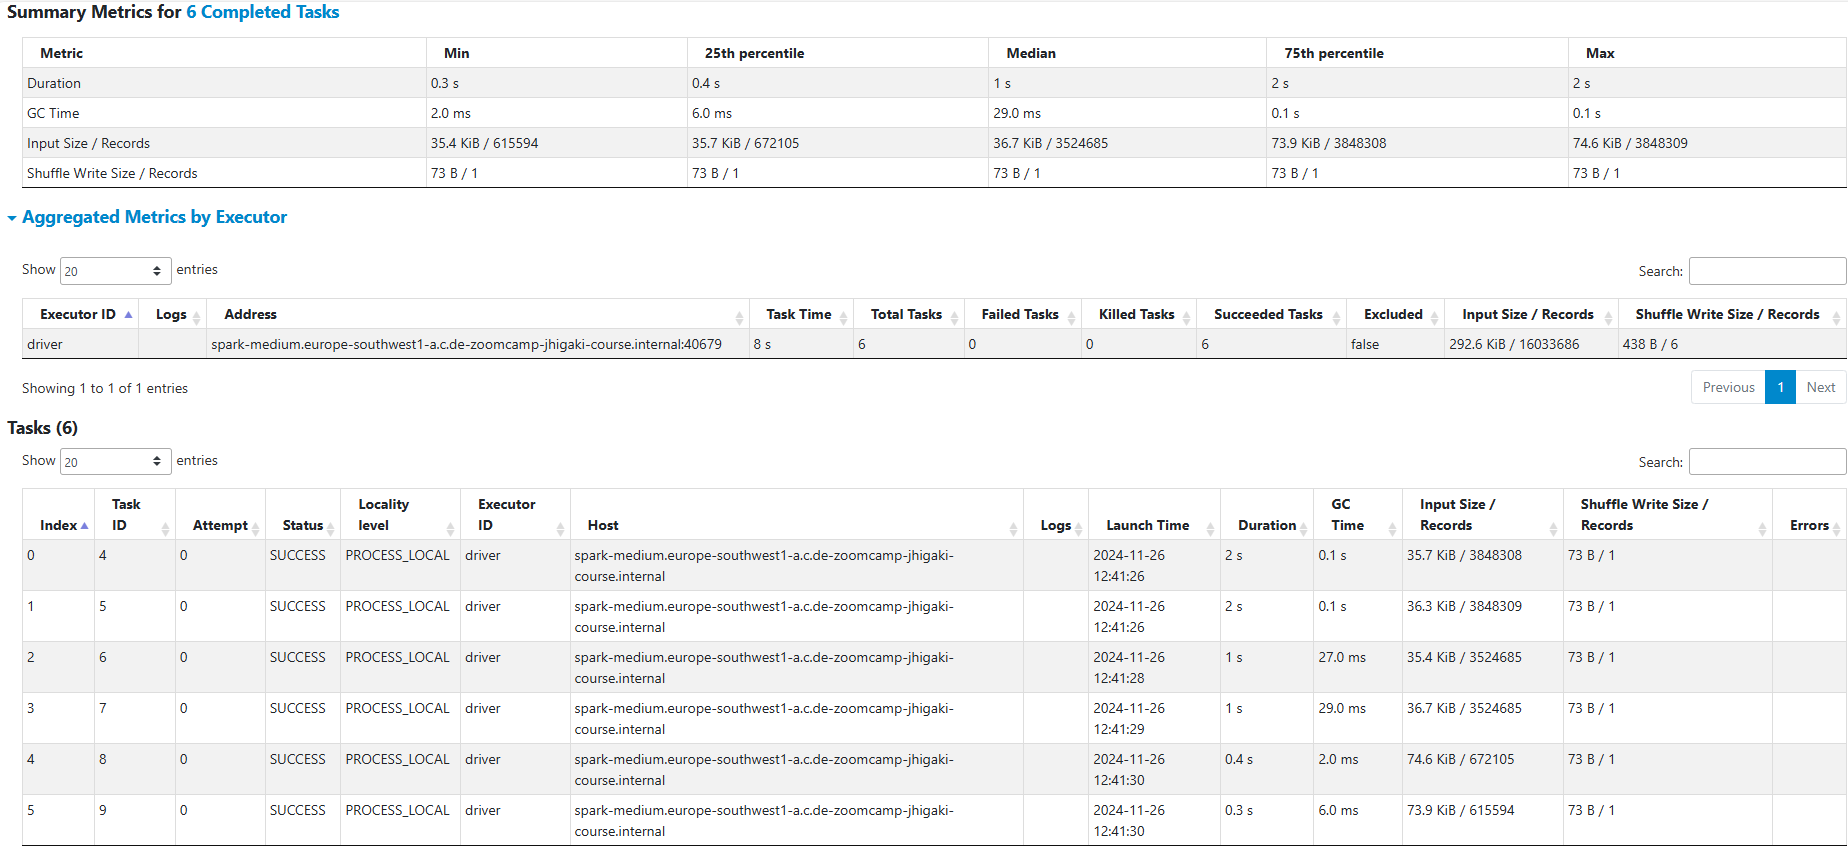  |


## Job 2
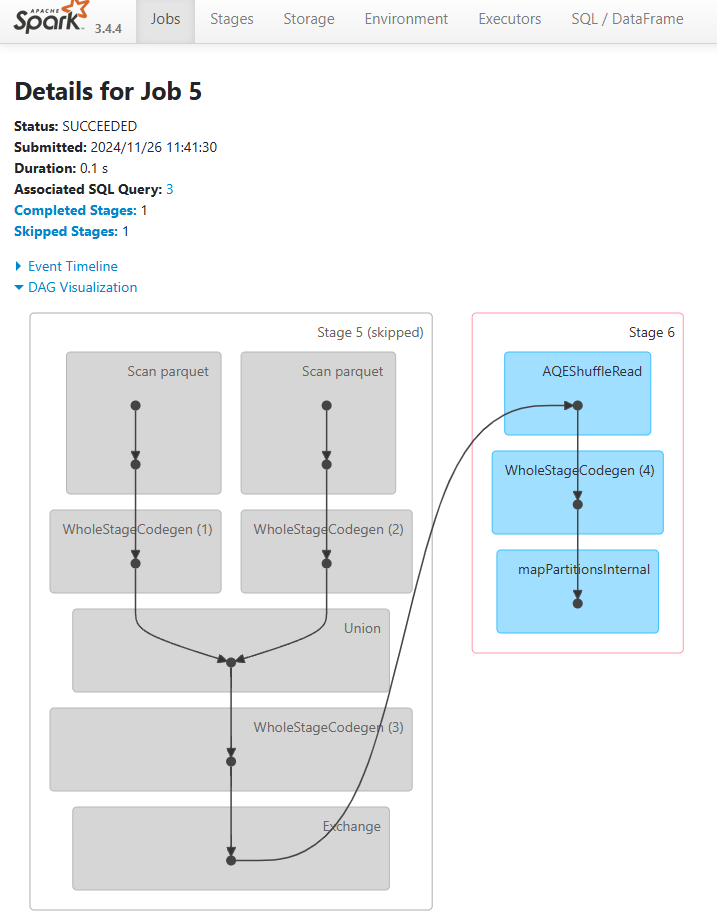


1 skipped stage (probably taken from previous step)
2nd stage : is this the count - group by?

| Stage's DAG | Stage's Metrics / Tasks  |
| --- | --- |
| 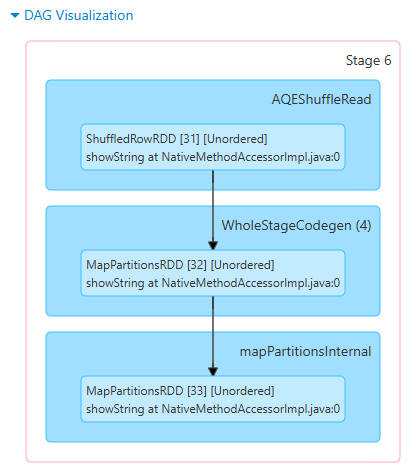 | 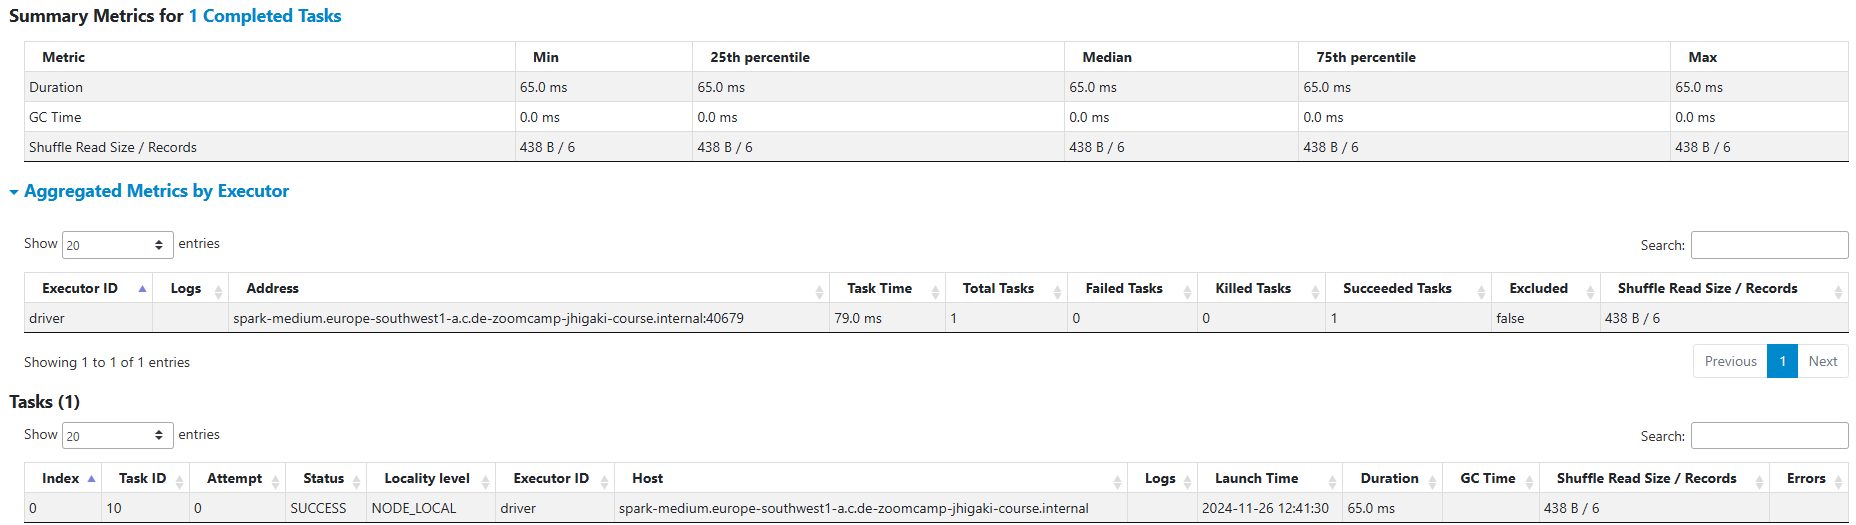 | 

Records column total:
16 033 686 
**I think it generated 6 task because I'm counting the entire dataset**